In [1]:
import nxsdk.api.n2a as nx
import numpy as np
import matplotlib.pyplot as plt
from nxsdk.utils.plotutils import plotRaster
# import our trace injection class
from nxsdk_modules.trace_injection.src.direct_trace_injection import DirectTraceInjection

# Direct Trace Injection

For learning, a synapse only has access to its own parameters (weight, delay, tag) and its pre- and post-synaptic traces. Some applications may need an external signal to use during training, such as a global error signal. This tutorial shows how a snip can be used to overwrite postsynaptic traces with values provided from python.

A snip will be used to overwrite trace values of the postsynaptic compartments just before learning executes. The list of new trace values will be provided by the superhost over a channel at every learning update.

![Direct Trace Injection](figures/jupyter_snips.png)

## The steps in this tutorial are:
1. Setup the network as usual
2. Create an instance of the *directTraceInjection* class, passing the constructor the compartment group to be overwritten 
3. Compile the network as usual
4. Call the *setupSnips()* function of the *directTraceInjection* instance to prepare the snips for execution
5. Start the board driver as usual
6. Call the *sendSnipInitialization()* function of the *directTraceInjection* instance to send the initialization data to the snip
7. Run the board with the *aSync=True* argument to make the call non-blocking
8. At each learning epoch, call the *write_y()* function of the directTraceInjection instance, passing a list of y trace values to be written to the compartment group 


## 1. Setup the Network

### Setup the compartments
In our case we will just create a single group of compartments called cx.

However, if we wanted to overwrite traces of arbitrary compartments in a network, we can put those compartments together in a group (a compartment can belong to many groups).

For example:
~~~~
cx=net.createCompartmentGroup()
cx.addCompartments(compartment1) #add existing compartment1 to the group
cx.addCompartments(compartment2) #add existing compartment2 to the group
cx.addCompartments(compartment3) #add existing compartment3 to the group
cx.addCompartments(compartmentGroup1[n]) #add the nth compartment (index starts at 0) of compartmentGroup1 to the group 
~~~~

We can then modify the traces of all compartments in cx. Note that adding a compartment to a group does not change the network structure unless you explicitly connect something to that group or modify some properties of the group.

In [2]:
net = nx.NxNet()

#how many neurons do we want in the group we'll be overwriting the traces of?
numTrainNeurons = 10

#Compartment group parameters
vThMant=50
compartmentCurrentDecay=int(1/5*2**12)
compartmentVoltageDecay=int(1/10*2**12)

# Compartment prototype
# We do not need to enable to the trace computation (enableLearning) because we'll be explicitly overwriting the trace values
# with our snip
cxProto = nx.CompartmentPrototype(vThMant=vThMant,
                                  compartmentCurrentDecay=compartmentCurrentDecay,
                                  compartmentVoltageDecay=compartmentVoltageDecay
                                 )

# Compartment group that we'll overwrite the traces of
cx = net.createCompartmentGroup(size=numTrainNeurons,
                                prototype=cxProto
                               )         


### Setup the learning rule and connection

This example only uses the y1 trace, but y2 and y3 traces can also be used.
Overwriting the y1 trace also requires overwriting the y2 and y3 traces. We cannot mix injected traces with traces computed by the compartment itself.

The learning rule here does not use x1 or x2, but there is no reason not to (try it). Since we do not use x1 or x2, we have not set up and x1 or x2 trace parameters.

y1, y2, and y3 trace computation parameters do not need to be set because we will overwrite any computed values.

y1 must always be positive, but using a bracketed term (y1-64) allows us to inject errors ranging from -64 to +63 by varying y1 from 0 to 127
~~~
dw = 'u0*(y1-64)-u0*w'
~~~
has the effect 
~~~
w = 'u0*(y1-64)' 
~~~
i.e. previous values of w do not affect the current value

In [3]:
dw='u0*(y1-64)-u0*w'

# How often will learning execute?
tEpoch = 50

lrTrain = net.createLearningRule(dw=dw,
                                 tEpoch=tEpoch
                                )

connProto = nx.ConnectionPrototype(enableLearning=1, 
                                   learningRule=lrTrain
                                  ) 


### Create Spike Generators

We use a constant spike rate input to the compartment group

In [4]:
# how long will we run the simulation for?
numSteps = 1000 

#inter spike interval
ISI = 10

# Create a presynaptic input spike generator for the learning synapses 
sgDataIn = net.createSpikeGenProcess(numPorts=1)

spikeTimes = list(range(0, numSteps, ISI))

sgDataIn.addSpikes(0, spikeTimes)

#define the synaptic weights connecting the spike generator to the post synaptic-learning compartment
weight=np.array([np.linspace(-64, 0, numTrainNeurons, endpoint=True)]).T

connLearn = sgDataIn.connect(cx,
                             prototype=connProto,
                             weight=weight
                            )


## Configure Probes

In [5]:
# see the compartment state
(uProbe, vProbe, sOutProbe) = cx.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,nx.ProbeParameter.COMPARTMENT_VOLTAGE,nx.ProbeParameter.SPIKE])

# see the state of the synapse
wLearnProbe = connLearn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)
tLearnProbe = connLearn.probe(nx.ProbeParameter.SYNAPSE_TAG)

## 2. Create an instance of the DirectTraceInjection class


In [6]:
dti = DirectTraceInjection(net=net,
                           compartmentGroup=cx,
                           enableY1=1,
                           enableY2=0,
                           enableY3=0)

## 3. Compile network and retrieve board

In [7]:
compiler = nx.N2Compiler()
board = compiler.compile(net)

## 4. Setup Snips

In [8]:
dti.setupSnips(board=board)

## 5. Start the board driver

In [9]:
board.startDriver()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861


## 6. Send the snip initialization data

The tix class has already determined internally which physical cores/compartments/traces to modify 

In [10]:
dti.sendSnipInitialization()

## 7. Run the board with the non-blocking "async=True" argument

In [11]:
board.run(numSteps, aSync=True)

## 8. At each epoch, send a list of trace values to write

If y2 and y3 were enabled when we initialized when we created tix, then we would need to send lists of trace values for y2 and y3 as well.

In [12]:
# how many learning epochs will there be in the run?
numLearningEpochs = int(numSteps/tEpoch)

# a simple list of values
y1ValueArray=weight.T[0] #initialize to the same values as the weights
y1Increment=-2*y1ValueArray/numLearningEpochs #how much to increment the weight by on each epoch

#for each learning epoch
for timestep in range(numLearningEpochs):
    y1ValueArray=y1ValueArray+y1Increment #increment the weights
    y1Values=[int(ii) for ii in (64+y1ValueArray).tolist()] #offset by 64 and convert to an integer list
    dti.writeY(y1Values=y1Values) #write the values to the compartment traces

## Cleanup and visualize

In [13]:
# Finish and disconnect
board.finishRun()
board.disconnect()

## Visualize results

Our learning rule has the effect w=y1, so we should see the weight increase as we write increasingly large y1 trace values to the compartment. When the weight gets large enough, the input spike train causes the post-synaptic compartment to spike. 

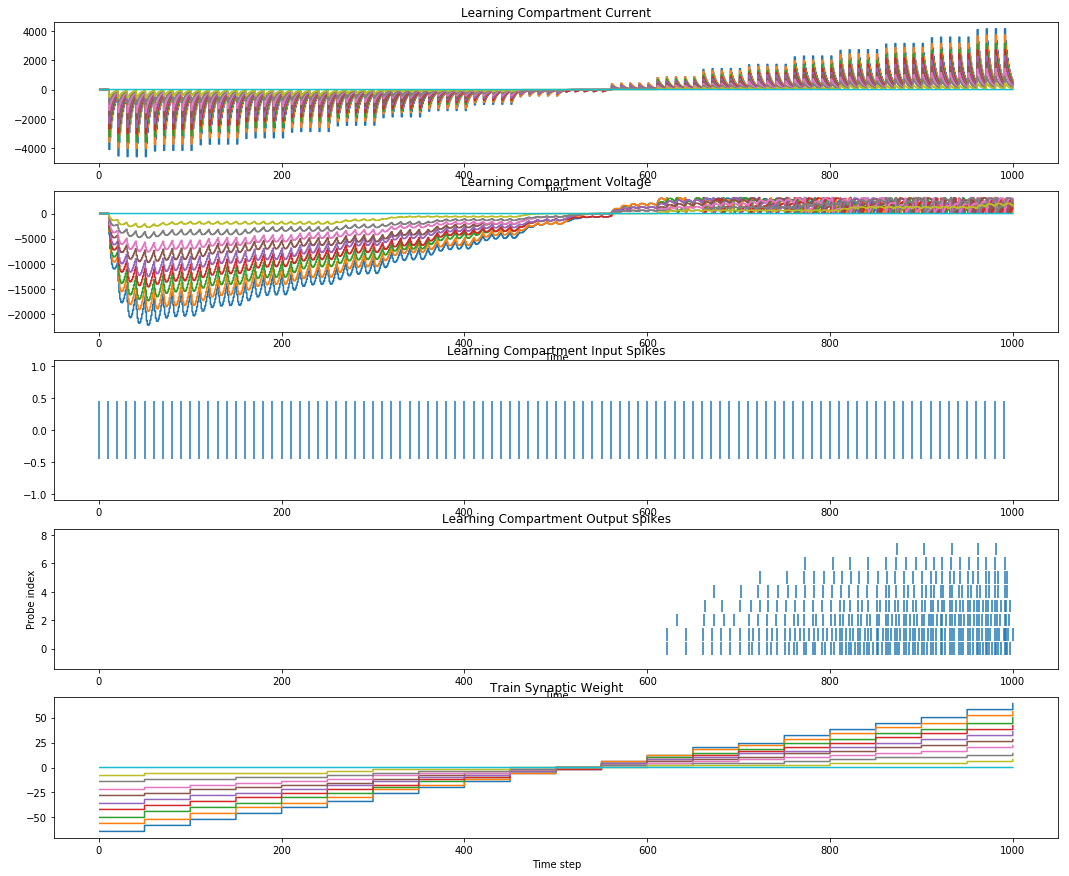

In [14]:
# Plot compartment current, voltage and spikes
numPlots = 5
plotNumber = 0
plt.figure(1, figsize=(18,numPlots*3))

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
uProbe.plot()
plt.title('Learning Compartment Current')
limits = ax.get_xlim()

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
vProbe.plot()
plt.title('Learning Compartment Voltage')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
plotRaster([spikeTimes])
plt.title('Learning Compartment Input Spikes')
ax.set_xlim(limits)

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
sOutProbe.plot()
plt.title('Learning Compartment Output Spikes')
ax.set_xlim(limits)

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(wLearnProbe)):
    wLearnProbe[ii][0].plot()
plt.title('Train Synaptic Weight')


plt.show()